In [1]:
import sys

sys.path.append('/home/anton/Documents/Tulane/Research/demo-vae/pip/src/')

from demovae import DemoVAE

field = 'f_46_0_0'

vae = DemoVAE(pperiod=50, use_cuda=True, nepochs=10000, latent_dim=120, weight_decay=0, lr=5e-5, loss_rec_mult=1e3,
              loss_pred_mult=0.01, loss_C_mult=1e4)
vae.load(f'/home/anton/Documents/Yale/UKB/VAE_Models/700_subs/{field}.pkl')

print('Done')

/home/anton/Documents/Tulane/Research/demo-vae/pip/src/demovae/sklearn.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dct = torch.load(path)


Done


In [2]:
import pickle

dct = pickle.load(open(f'/home/anton/Documents/Yale/UKB/VAE_Models/700_subs/demos_{field}.pkl', 'rb'))

print(list(dct.keys()))
print('Done')

['demos', 'types']
Done


In [3]:
# Load ADNI model

import pickle

# adni = pickle.load(open('/home/anton/Documents/Tulane/Research/Work/ADNI/weights0.pkl', 'rb'))
adni = {'coef': None, 'intercept': 0}
adni['coef'] = pickle.load(open('/home/anton/Documents/Tulane/Research/Work/ADNI/corrBalanced.pkl', 'rb'))

list(adni.keys())

['coef', 'intercept']

In [5]:
# Load sub FCS

import numpy as np

inter_subs_fc = pickle.load(open('/home/anton/Documents/Yale/UKB/inter_subs_fc.pkl', 'rb'))
fcs = []
count = 0

for sub in inter_subs_fc:
    p = np.load(f'/home/anton/Documents/Tulane/Research/ImageNomer/data/UKB3/conn/{sub}_task-20227-2_fc.npy')
    fcs.append(p)
    count += 1
    if count == 700:
        break

fcs = np.stack(fcs)
print(len(fcs))

700


In [230]:
dct['demos'][4][:20]

array([18., 50., 42., 28., 12., 32., 16., 26., 44., 45., 42., 41., 50.,
       46., 20., 21., 30., 26., 30., 46.])

In [24]:
import numpy as np

vals = []
synth_mean = np.zeros(34716)

for i in range(20):
    # synth = vae.transform(len(dct['demos'][0]), dct['demos'], dct['types'])
    synth = vae.transform(fcs, dct['demos'], dct['types'])
    synth_mean += np.mean(synth, axis=0)/20
    
    b = adni['intercept']
    w = adni['coef']
    sum_logits = 0
    
    for fc in synth:
        logits = b+np.sum(fc*w)
        sum_logits += logits
    
    vals.append(sum_logits/len(synth))

print(np.mean(vals))
print(np.std(vals))

-232.98889578705547
2.842170943040401e-14


In [26]:
vals = []
nsynth_mean = np.zeros(34716)

for i in range(20):
    ndemo = []
    for d in dct['demos']:
        dd = d+0
        ndemo.append(dd)

    # ndemo[1] = 1*np.ones(len(ndemo[1]))
    ndemo[2] -= 20
    # ndemo[4] = 1*np.ones(len(ndemo[4]))
    # ndemo[0] -= 20
    
    # nsynth = vae.transform(len(dct['demos'][0]), ndemo, dct['types'])
    nsynth = vae.transform(fcs, ndemo, dct['types'])
    nsynth_mean += np.mean(nsynth, axis=0)/20

    b = adni['intercept']
    w = adni['coef']
    sum_logits = 0
    
    for fc in nsynth:
        logits = b+np.sum(fc*w)
        sum_logits += logits
    
    vals.append(sum_logits/len(nsynth))

print(np.mean(vals))
print(np.std(vals))

-228.21693046698297
5.684341886080802e-14


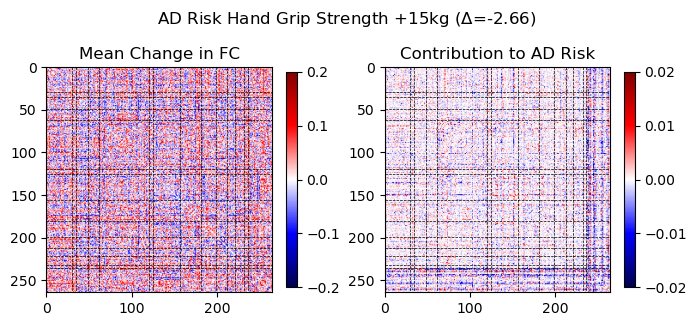

In [234]:
# Make two graphs: one mean change in FC, the other mean change in AD risk
# Use seismic or RdBu colormaps

divis = [0,30,35,49,62,120,125,156,181,199,212,221,232,236,264]
labels = ['SMTH','SMTM','CNG','AUD','DMN','MEM','VIS','FRNT','SAL','SUB','VTRL','DRSL','CBL','UNK']

def getlabel(i):
    for j in range(len(divis)):
        if i >= divis[j] and i < divis[j+1]:
            return labels[j]

def vec2mat(v):
    a,b = np.triu_indices(264,1)
    m = np.zeros((264,264))
    m[a,b] = v
    return m+m.T

import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm

fig, ax = plt.subplots(1,2,figsize=(8,3.5))

subject = 'Hand Grip Strength +15kg'
delta = '-2.66'
diff = nsynth_mean-synth_mean
diffw = w*diff
tit = subject.replace(' ', '_')
scale = 0.2

norm1 = TwoSlopeNorm(vmax=scale, vmin=-scale, vcenter=0)
norm2 = TwoSlopeNorm(vmax=scale/10, vmin=-scale/10, vcenter=0)

pos = ax[0].imshow(vec2mat(diff), norm=norm1, cmap='seismic')
fig.colorbar(pos, ax=ax[0], shrink=0.8)

pos = ax[1].imshow(vec2mat(diffw), norm=norm2, cmap='seismic')
fig.colorbar(pos, ax=ax[1], shrink=0.8)

for i in range(len(divis)-1):
    d = divis[i+1]
    ax[0].plot([0, 264], [d, d], color='black', linewidth=0.5, linestyle='--')
    ax[0].plot([d, d], [0, 264], color='black', linewidth=0.5, linestyle='--')
    ax[1].plot([0, 264], [d, d], color='black', linewidth=0.5, linestyle='--')
    ax[1].plot([d, d], [0, 264], color='black', linewidth=0.5, linestyle='--')

ax[0].set_xlim([0,264])
ax[0].set_ylim([264,0])
ax[1].set_xlim([0,264])
ax[1].set_ylim([264,0])

ax[0].set_title('Mean Change in FC')
ax[1].set_title('Contribution to AD Risk')

fig.suptitle(f'AD Risk {subject} ($\\Delta$={delta})')
fig.show()
fig.savefig(f'/home/anton/Documents/Yale/UKB/Figures/FCChanges/{tit}.pdf')

In [235]:
# Individual ROIs

a,b = np.triu_indices(264,1)
top = np.argsort(np.abs(diffw))[::-1]
num = 8

print(tit, delta)
print('Individual ROIs')
for i in range(num):
    r1 = a[top[i]]
    r2 = b[top[i]]
    print(top[i], r1, r2, getlabel(r1), getlabel(r2), diffw[top[i]])

vals = []
sums = []
labs = []
W = vec2mat(diffw)

for i in range(len(divis)-1):
    for j in range(i,len(divis)-1):
        r1a = divis[i]
        r1b = divis[i+1]
        r2a = divis[j]
        r2b = divis[j+1]
        val = np.mean(W[r1a:r1b,r2a:r2b])
        vals.append(val)
        val = np.sum(W[r1a:r1b,r2a:r2b])
        sums.append(val)
        labs.append(f'{labels[i]}-{labels[j]}')

idcs = np.argsort(np.abs(vals))[::-1]

print('Networks Mean')
for i in range(num):
    print(vals[idcs[i]], labs[idcs[i]])

idcs = np.argsort(np.abs(sums))[::-1]

print('Networks Sum')
for i in range(num):
    print(sums[idcs[i]], labs[idcs[i]])

Hand_Grip_Strength_+15kg -2.66
Individual ROIs
14991 64 240 DMN UNK -0.04073623709989598
32478 196 237 SAL UNK -0.03627260841379621
34416 239 240 UNK UNK 0.033081741834467486
32544 197 237 SAL UNK -0.031321198762772014
34445 240 246 UNK UNK -0.031086933541039287
29742 163 240 FRNT UNK -0.029006515526674135
34421 239 245 UNK UNK 0.028219761294501725
29642 162 240 FRNT UNK -0.028054862734143506
Networks Mean
-0.0020314264022002287 SMTM-SMTM
-0.0018784083101315288 SMTM-UNK
0.0015169511300051008 SMTM-MEM
-0.0013197142860104734 CBL-UNK
-0.0012427345602822391 SAL-UNK
-0.0010871180277640536 FRNT-UNK
-0.0009822407948284376 UNK-UNK
-0.0008870794827145185 DMN-UNK
Networks Sum
-1.440617079928378 DMN-UNK
-0.7700767831454951 UNK-UNK
-0.7609826194348375 FRNT-UNK
-0.6263382183822486 SAL-UNK
-0.5945340581489216 SMTH-UNK
-0.4664664524396013 DMN-VIS
0.43510325820880913 VIS-VIS
-0.4336457703571218 DMN-DMN
